<a href="https://colab.research.google.com/github/sagunkayastha/Cell_Seg_count/blob/master/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf cell_images cell_images.zip*
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!mkdir /content/cell_images
!mkdir /content/cell_images/train /content/cell_images/test 
!unzip -q cell_images.zip -d /content/cell_images/train/
!mv -f /content/cell_images/train/cell_images/* /content/cell_images/train/
!rm -rf /content/cell_images/train/cell_images

--2019-04-03 11:04:27--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  44.8MB/s    in 5.9s    

2019-04-03 11:04:33 (57.1 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [ ]:
import shutil
import numpy as np
import os
import sys 
import random

train_path = 'cell_images/train'

a = np.array(os.listdir(train_path+'/Uninfected'))
b = np.array(os.listdir(train_path+'/Parasitized'))
indx = random.sample(0range(10000), 20)
for i,j in zip(a[indx],b[indx]):
  shutil.copyfile(train_path+'/Uninfected/'+i, '/content/cell_images/test/'+i)
  shutil.copyfile(train_path+'/Parasitized/'+j, '/content/cell_images/test/'+j)
!mkdir /content/cell_images/test/test 
!mv /content/cell_images/test/*.png /content/cell_images/test/test

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import ModelCheckpoint
train_path = 'cell_images/train'

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (64, 64),
    color_mode = 'rgb',
    shuffle=True,
    batch_size = batch_size,
    class_mode = 'categorical')



Using TensorFlow backend.


Found 27558 images belonging to 2 classes.


In [ ]:
import numpy as np
from keras.callbacks import ModelCheckpoint


In [ ]:
# model.summary()
# new_model = Sequential() #new model
# for layer in model.layers: 
#     new_model.add(layer)
from keras.layers import Dropout, Flatten, Dense, Activation
model = Sequential()
model.add(Conv2D(filters=64, input_shape=(64,64,3), kernel_size=(3,3), strides=(1,1), padding='same',kernel_initializer='he_normal'))   
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')) 


model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same',kernel_initializer='he_normal'))    
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
          
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',kernel_initializer='he_normal'))    
model.add(Activation('relu'))    
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))       
          

model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',kernel_initializer='he_normal'))    
model.add(Activation('relu'))    
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))       
            
          
model.add(Flatten())
model.add(Dense(512,input_shape=(4*4*512,),activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.summary()
model_checkpoint = ModelCheckpoint("malaria.h5", monitor='loss', save_best_only=True)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv

In [ ]:
# try:
#     model.load_weights("malaria.h5")
#     print('Model LOafed')
# except:
#     pass
import tensorflow as tf
from keras import backend as K
tf.set_random_seed(1234)

from keras.optimizers import SGD
opt = SGD(lr=0.1)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ['categorical_accuracy'])

# learn_rate = 0.01
# adm = keras.optimizers.Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(optimizer=adm,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model.fit_generator(train_generator,
                            steps_per_epoch = 22758/16,
                            nb_epoch =  50,
                   callbacks = [model_checkpoint])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1422.375, callbacks=[<keras.ca..., epochs=50)`
  from ipykernel import kernelapp as app


Epoch 1/50
 115/1422 [=>............................] - ETA: 2:21 - loss: 2.5417 - categorical_accuracy: 0.5087

KeyboardInterrupt: ignored

In [ ]:
 2 test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'cell_images/test/',
        target_size=(64, 64),
        color_mode="rgb",
        shuffle = False,
        class_mode='binary',
        batch_size=1)


In [ ]:
import matplotlib.pyplot as plt
import cv2
test_dir = '/content/cell_images/test/test/'
a = os.listdir(test_dir)

img = plt.imread(test_dir+a[5])
plt.imshow(img)
plt.show()
img = cv2.resize(img, (64,64))
plt.imshow(img)
plt.show()

img = np.expand_dims(img, axis = 0)
# '/content/cell_images/test/'
pred = model.predict(img)
print(pred)

In [ ]:
|pred = model.predict_generator(test_generator, steps = len(test_generator)) 

In [ ]:
for i in range(len(pred)):
  print(f'{pred[i]} ')
#   print(next(test_generator)[0][0].shape)
#   plt.imshow(next(test_generator)[0][0])
#   plt.show()

In [ ]:
a = np.zeros((64,64,3))

In [ ]:
a2 = np.expand_dims(a, axis=0)
print(a.shape, a2.shape)

In [ ]:
!wget https://archive.org/download/ChestXray-NIHCC/ChestXray-NIHCC/images_001.tar.gz

--2019-05-03 14:28:27--  https://archive.org/download/ChestXray-NIHCC/ChestXray-NIHCC/images_001.tar.gz
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia800102.us.archive.org/15/items/ChestXray-NIHCC/ChestXray-NIHCC/images_001.tar.gz [following]
--2019-05-03 14:28:28--  https://ia800102.us.archive.org/15/items/ChestXray-NIHCC/ChestXray-NIHCC/images_001.tar.gz
Resolving ia800102.us.archive.org (ia800102.us.archive.org)... 207.241.232.12
Connecting to ia800102.us.archive.org (ia800102.us.archive.org)|207.241.232.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008470987 (1.9G) [application/octet-stream]
Saving to: ‘images_001.tar.gz.2’

images_001.tar.gz.2   4%[                    ]  87.74M  1.55MB/s    eta 16m 31s^C


In [ ]:
# source:
# https://stackoverflow.com/questions/6051877/loading-magnet-link-using-rasterbar-libtorrent-in-python
#
# ATTENTION: This is only a example of to use a python bind of torrent library in Python for educational purposes.
#            I am not responsible for your download of illegal content or without permission.
#            Please respect the laws license permits of your country.

import libtorrent as lt
import time

ses = lt.session()
ses.listen_on(6881, 6891)
params = {
    'save_path': '/',
    'storage_mode': lt.storage_mode_t(2),
    'paused': False,
    'auto_managed': True,
    'duplicate_is_error': True}
link = "magnet:?xt=urn:btih:cd41eab5bc591e0e8c0ff6d7c1ca939fae2eff76&dn=ChestXray-NIHCCE"
handle = lt.add_magnet_uri(ses, link, params)
ses.start_dht()

print ('downloading metadata...')
while (not handle.has_metadata()):
    time.sleep(1)
print ('got metadata, starting torrent download...')
while (handle.status().state != lt.torrent_status.seeding):
    s = handle.status()
    state_str = ['queued', 'checking', 'downloading metadata', \
            'downloading', 'finished', 'seeding', 'allocating']
    print ('%.2f%% complete (down: %.1f kb/s up: %.1f kB/s peers: %d) %s' % \
            (s.progress * 100, s.download_rate / 1000, s.upload_rate / 1000, \
            s.num_peers, state_str[s.state]))
    time.sleep(5)

downloading metadata...


KeyboardInterrupt: ignored

In [ ]:
!git clone https://github.com/Yijunmaverick/CartoonGAN-Test-Pytorch-Torch

Cloning into 'CartoonGAN-Test-Pytorch-Torch'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 11.99 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
!ls

62
Fitting the classifier to the training set
Iteration 1, loss = 1.53254076
Validation score: 0.575000
Iteration 2, loss = 1.10390525
Validation score: 0.575000
Iteration 3, loss = 0.86760894
Validation score: 0.650000
Iteration 4, loss = 0.68424235
Validation score: 0.687500
Iteration 5, loss = 0.53277538
Validation score: 0.725000
Iteration 6, loss = 0.41971351
Validation score: 0.750000
Iteration 7, loss = 0.33765807
Validation score: 0.737500
Iteration 8, loss = 0.27434059
Validation score: 0.775000
Iteration 9, loss = 0.22642882
Validation score: 0.800000
Iteration 10, loss = 0.18793233
Validation score: 0.787500
Iteration 11, loss = 0.15710654
Validation score: 0.787500
Iteration 12, loss = 0.13225746
Validation score: 0.775000
Iteration 13, loss = 0.11164751
Validation score: 0.787500
Iteration 14, loss = 0.09587837
Validation score: 0.787500
Iteration 15, loss = 0.08296094
Validation score: 0.800000
Iteration 16, loss = 0.07191282
Validation score: 0.800000
Iteration 17, loss 

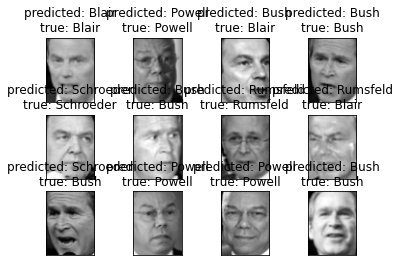

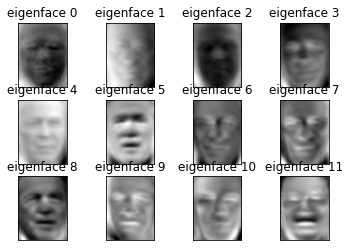

In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier


# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=100)

_, h, w = lfw_dataset.images.shape
print(h)
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = VGGFace(model='resnet50')
model.train(X_train)
# # Compute a PCA 
# n_components = 100
# pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# # apply PCA transformation to training data
# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)


# train a neural network
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(X_train_pca, y_train)
clf = model()


y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))


# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

def titles(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)

prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)


eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()


In [ ]:
h, w


(62, 47)

In [ ]:
62*47

2914

In [ ]:
!touch requirements.txt

In [ ]:
!pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/69/43/380514bd9663f1bf708abeb359b8b48d3fabb1c8e95bb3427a980a064c57/torch-0.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/68/1e/116ad560de97694e2d0c1843a7a0075cc9f49e922454d32f49a80eb6f1f2/numpy-1.14.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/35/96/6e71a040339d4efc54cf707061e70fd624c9120b48b992f919ba34df9cb1/matplotlib-2.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/93/24/6ab1df969db228aed36a648a8959d1027099ce45fad67532b9673d533318/tqdm-4.23.4-py2.py3-none-any.whl
     |███████████████████████████████▌| 834.1MB 42.9MB/s eta 0:00:01tcmalloc: large alloc 1147494400 bytes == 0x3a0a2000 @  0x7ffb8e0fa615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
